In [1]:
import sys 
sys.path.append('../')
import os
from deephive.environment.deephive_utils import *
from deephive.environment.utils import *
import numpy as np 
from deephive.exploration.gp_surrogate import GPSurrogateModule
from deephive.environment.utils import filter_points
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
import json

Using device: cpu


In [53]:
def get_agent_actions(env, policy, obs, config, roles=None, split_agents=False,
                      split_type="use_stds", decay_std=False, split_ratio=1, dynamic_split=False, **kwargs):
    
    if decay_std:
        policy.std_controller.decay_std()
    if split_agents==False:
        if config["variable_std"][0] == True:
            obs_std = policy.std_controller.get_all_std()
            actions = get_action(obs, policy, env, obs_std)
        else:
            actions = get_action(obs, policy, env)
        return actions
    elif split_agents==True:
        assert roles is not None, "Roles must be provided if split_agents is True"
        if kwargs.get("exploiter_ids") is not None: 
            exploiters_id = kwargs.get("exploiter_ids")
            explorers_id = kwargs.get("explorer_ids")
        else:
            if not dynamic_split:
                exploiters_id = np.where(roles[0] == 1)[0]
                explorers_id = np.where(roles[0] == 0)[0]
            else:
                # use the split ratio to split the agents
                explorers_id = np.random.choice(env.n_agents, int(env.n_agents * split_ratio), replace=False)
                exploiters_id = np.setdiff1d(np.arange(env.n_agents), explorers_id)
        roles = np.zeros((env.n_agents))
        for i in range(len(exploiters_id)):
            roles[int(exploiters_id[i])] = 1
        for i in range(len(explorers_id)):
            roles[int(explorers_id[i])] = 0
            
        roles = [roles, roles]
        # update env state history roles to the correct exploration/exploitation roles
        env.state_history[:, env.current_step, -2] = roles[0]
        
        if split_type == "use_stds":
            policy.std_controller.update_roles(roles)
            obs_std = policy.std_controller.get_all_std()
            #print(obs_std)
            assert config['variable_std'][0] == True, "variable_std must be True in config"
            assert config['role_std']['explorer'] > config['role_std']['exploiter'], "explorers must have higher std than exploiters"
            actions = get_action(obs, policy, env, obs_std)
            return actions
        elif split_type == "use_grid":
            policy.std_controller.update_roles(roles)
            obs_std = policy.std_controller.get_all_std()
            explorer_actions, _ = get_informed_action(env, env.n_agents)
            exploiter_actions = get_action(obs, policy, env, obs_std)
            actions = np.zeros((env.n_agents, env.n_dim))
            if explorers_id.size > 0:
                actions[explorers_id] = explorer_actions[explorers_id]
            if exploiters_id.size > 0:
                # print(exploiters_id.size)
                # print(exploiters_id)
                actions[exploiters_id] = exploiter_actions[exploiters_id]
            return actions
        elif split_type == "use_two_policies":
            policy[0].std_controller.update_roles(roles)
            obs_std = policy[0].std_controller.get_all_std()
            obs_explore, roles = env.observation_schemes.generate_observation(pbest=env.pbest.copy(), use_gbest=False, ratio=env.split_ratio)
            obs_exploit, roles = env.observation_schemes.generate_observation(pbest=env.pbest.copy(), use_gbest=True, ratio=env.split_ratio)
            exploit_std_obs = policy[1].std_controller.get_all_std(std=config["exploit_std"])
            assert len(policy) == 2, "Two policies must be provided - first policy is for explorers and second policy is for exploiters"
            explorer_actions = get_action(obs_explore, policy[0], env, obs_std)
            exploiter_actions = get_action(obs_exploit, policy[1], env, exploit_std_obs)
            actions = np.zeros((env.n_agents, env.n_dim))
            if explorers_id.size > 0:
                actions[explorers_id] = explorer_actions[explorers_id]
            if exploiters_id.size > 0:
                actions[exploiters_id] = exploiter_actions[exploiters_id]
            return actions
            
            
        


def optimize(env, agent_policy, obs, roles, config):
    gbests = []
    split_interval = config['split_interval']
    exploiters_id = np.array([])
    explorers_id = np.arange(env.n_agents)
    for i in range(config['ep_length']):
        if i == config['decay_start']:
            decay_std_run = config['decay_std']
        if i % split_interval == 0:
            #env.render()
            if i != 0:
                if len(explorers_id) > 0:
                    # add one explorer to the exploiters
                    exploiters_id = np.append(exploiters_id, int(explorers_id[0]))
                    # remove the explorer from the explorers
                    explorers_id = explorers_id[1:]
            explorers_id = np.array(explorers_id).astype(int) if len(explorers_id) > 0 else np.array([])
            exploiters_id = np.array(exploiters_id).astype(int) if len(exploiters_id) > 0 else np.array([])

            
                # add one explorer to the exploiters
        actions = get_agent_actions(env, agent_policy, obs, config, roles=roles, split_agents=config["split_agents"], 
                                    split_type=config["split_type"], decay_std=decay_std_run, split_ratio=config["split_ratio"],
                                    dynamic_split=config["dynamic_split"], exploiter_ids=exploiters_id, explorer_ids=explorers_id)
        observation_info, _, _, _ = env.step(actions)
        obs, roles = observation_info
        gbests.append(env.gbest[-1])
    return gbests
        
def run_experiment(env, agent_policy, config, exp_name, save_gif=False):
    result_path = 'experiments/results/' + exp_name + '/'
    os.makedirs(result_path, exist_ok=True)
    
    if isinstance(agent_policy, list):
        assert config['split_agents'] == True, "split_agents must be True in config"
        assert config['split_type'] == "use_two_policies", "split_type must be use_two_policies in config"
        assert len(agent_policy) == 2, "Two policies must be provided - first policy is for explorers and second policy is for exploiters"
    
    opt_value = env.objective_function.optimal_value(dim=env.n_dim)
    gbestVals = []
    for iter in range(config['iters']):
        obs, roles = env.reset()
        if isinstance(agent_policy, list):
            agent_policy[0].std_controller.reset_std()
            agent_policy[1].std_controller.reset_std()
        else:
            agent_policy.std_controller.reset_std()
        episode_gbest = []
        episode_gbest.append(env.gbest[-1])
        decay_std_run = False
        
        gbests = optimize(env, agent_policy, obs, roles, config)
        # combine gbests to episode gbest
        episode_gbest.extend(gbests)
        print(f"Episode gbests - {episode_gbest}")
        
        

        if env.gbest[-1] < config['tol'] * opt_value:
            print(f"[WARNING - iter {iter}] - Optimization failed to get to {config['tol']}% of optimal value - {opt_value}")
            print(f"Best value found: {env.gbest[-1]}")
            print("Rendering the episode history ...")
            print("------------------------------------------")
            env.render(type="history", file_path=result_path + "error_history_" + str(iter) + "_.gif")
        if save_gif:
            if iter % 2 == 0:
                env.render(type="history", file_path=result_path + "history_" + str(iter) + "_.gif")
        gbestVals.append(episode_gbest)
        
    # save gbestVals
    np.save(result_path + "gbestVals.npy", np.array(gbestVals))
        
    if config['plot_gbest']:
            num_function_evaluation(fopt=gbestVals ,n_agents=env.n_agents, save_dir=result_path + "num_function_evaluations.png", opt_value=opt_value,
                                    log_scale=False, plot_error_bounds=True)
            plot_individual_function_evaluation(fopt=gbestVals ,n_agents=env.n_agents, save_dir=result_path + "num_function_evaluations2.png", opt_value=opt_value,
                                    log_scale=False)
            
    run_summary = {
    "split_agents": config['split_agents'],
    "split_type": config['split_type'],
    "decay_std": config['decay_std'],
    "decay_start": config['decay_start'],
    "freeze": config['freeze'],
    "use_gbest": config['use_gbest'],
    "variable_std": config['variable_std'],
    "role_std": config['role_std'],
    "decay_std": config['decay_std'],
}
    
    with open(result_path + "run_summary.json", 'w') as f:
        json.dump(run_summary, f)
        

In [16]:
# #Experiment 1: VARIANCE DRIVEN EXPLORERS AND EXPLOITERS
config_path = "../config/exp_config.json"
model_path = "../models/pbest_unfreeze.pth"
model_path_2 = "../models/gbest.pth"

config = parse_config(config_path)


## MANUAL INSPECTION

In [ ]:
# obs, roles = env.reset()
# pbest_policy.std_controller.reset_std()
# # env.render()
# for i in range(10):
#     pbest_policy.std_controller.decay_std()
#     pbest_policy.std_controller.update_roles(roles)
#     observation_std = pbest_policy.std_controller.get_all_std()
#     # print(observation_std[0])
#     # print(env.gbest)
#     exploiters_id = np.where(roles[0] == 1)[0]
#     explorers_id = np.where(roles[0] == 0)[0]
#     actions = get_action(obs, observation_std, pbest_policy, env)
#     observation_info, reward, done, info = env.step(actions)
#     obs, roles = observation_info
#     # env.render()


# NO SPLITTING

## NO SPLITTING - DECAY STD - UNFREEZE - 4

In [ ]:
exp_num = 106
iters = 10
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

config['freeze'] = False
config['use_gbest'] = True
config['role_std'] = {'explorer': 0.5, 'exploiter': 0.02}
config['exploit_std'] = 0.02
config['variable_std'] = True,
config['action_std'] = 0.5
config['decay_rate'] = 0.9
config['decay_std'] = False
config['decay_start'] = 0
config['split_agents'] = True
config['split_type'] = "use_grid"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
config['split_ratio'] = 0.5
config['dynamic_split'] = False
config['ep_length'] = 20
config['split_interval'] = 2
config['n_agents'] = 10
config['n_dim'] = 2
config['objective_function'] = "CosineMixtureFunction"
config['grid_resolution'] = 0.1
mode = "test"
env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
agent_policies = gbest_policy
run_experiment(env, agent_policies, config, exp_name, save_gif=True)

In [25]:
import numpy as np

# Example setup (replace with your actual setup)
env = type('env', (), {'n_agents': 10, 'n_dim': 5})  # Replace with your actual environment
explorer_actions = np.random.rand(env.n_agents, env.n_dim)  # Example actions
exploiter_actions = np.random.rand(env.n_agents, env.n_dim)  # Example actions

# Your original arrays of IDs (make sure these are correct)
explorers_id = np.array([0, 2, 4])  # Example IDs
exploiters_id = np.array([1, 3, 5])  # Example IDs

actions = np.zeros((env.n_agents, env.n_dim))

# Check if the IDs are within bounds
if np.any(explorers_id >= env.n_agents) or np.any(exploiters_id >= env.n_agents):
    raise ValueError("One or more IDs are out of bounds.")

# Apply actions based on the IDs
if explorers_id.size > 0:
    actions[explorers_id] = explorer_actions[explorers_id]
if exploiters_id.size > 0:
    actions[exploiters_id] = exploiter_actions[exploiters_id]

# Check result
print(actions)


[[0.17567889 0.29277935 0.91475346 0.45389328 0.83194692]
 [0.8450587  0.4344118  0.49220258 0.74343706 0.34880538]
 [0.74905862 0.58689934 0.11989125 0.72701785 0.59017463]
 [0.87197117 0.44002802 0.11613758 0.87210742 0.37826404]
 [0.89325436 0.79960933 0.66113012 0.87125064 0.35801147]
 [0.80045189 0.37179538 0.31768617 0.67746179 0.32891757]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


## NO SPLITTING - DECAY STD - FREEZE - 6

In [ ]:
exp_num = 60
iters = 100
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

config['freeze'] = True
config['use_gbest'] = False
config['role_std'] = {'explorer': 0.3, 'exploiter': 0.3}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.9
config['decay_std'] = True
config['decay_start'] = 0
config['split_agents'] = False
config['split_type'] = "use_stds"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
mode = "test"
env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, pbest_policy, config, exp_name)

## NO SPLITTING - WITH DECAYED STD - DELAYED DECAY - 5, 7, 8

In [ ]:
exp_num = 9
iters = 100
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

config['freeze'] = False
config['use_gbest'] = False
config['role_std'] = {'explorer': 0.4, 'exploiter': 0.4}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.9
config['decay_std'] = True
config['decay_start'] = 4
config['split_agents'] = False
config['split_type'] = "use_stds"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
mode = "test"
env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, pbest_policy, config, exp_name)

NO SPLITTING - WITH DECAYED STD - DELAYED DECAY - FREEZE - 9 & 10

In [ ]:
exp_num = 10
iters = 100
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

config['freeze'] = True
config['use_gbest'] = False
config['role_std'] = {'explorer': 0.4, 'exploiter': 0.4}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.95
config['decay_std'] = True
config['decay_start'] = 4
config['split_agents'] = False
config['split_type'] = "use_stds"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
mode = "test"
env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, pbest_policy, config, exp_name)

In [ ]:
env.reset()

## SPLITTING - WITH STDs - 11

In [ ]:
exp_num = 11
iters = 100
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

config['freeze'] = False
config['use_gbest'] = False
config['role_std'] = {'explorer': 0.2, 'exploiter': 0.02}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.9
config['decay_std'] = False
config['decay_start'] = 0
config['split_agents'] = True
config['split_type'] = "use_stds"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
mode = "test"

env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, pbest_policy, config, exp_name)

## SPLITTING - TWO POLICIES - 12

In [ ]:
exp_num = 14
iters = 100
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)


config['freeze'] = False
config['use_gbest'] = False
config['role_std'] = {'explorer': 0.4, 'exploiter': 0.4}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.9
config['decay_std'] = False
config['decay_start'] = 0
config['split_agents'] = True
config['split_type'] = "use_two_policies"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
config['exploit_std'] = 0.02
mode = "test"

env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, agent_policies, config, exp_name)

## SPLITTING - GRID METHOD - 13 and 14

In [ ]:
exp_num = 15
iters = 100
exp_name = "exp_" + str(exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

config['freeze'] = False
config['use_gbest'] = True
config['role_std'] = {'explorer': 0.02, 'exploiter': 0.02}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.9
config['decay_std'] = False
config['decay_start'] = 0
config['split_agents'] = True
config['split_type'] = "use_grid"
config['plot_gbest'] = True
config['iters'] = iters
config['tol'] = .99
config['exploit_std'] = 0.02
mode = "test"

env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, gbest_policy, config, exp_name, save_gif=True)

In [ ]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--title', type=str, default='test')
parser.add_argument('--exp_num', type=int, default=1)
parser.add_argument('--iters', type=int, default=100)
parser.add_argument('--freeze', type=bool, default=False)
parser.add_argument('--use_gbest', type=bool, default=False)
parser.add_argument('--role_std_exploiters', type=float, default=0.2)
parser.add_argument('--role_std_explorers', type=float, default=0.2)
parser.add_argument('--variable_std', type=bool, default=True)
parser.add_argument('--action_std', type=float, default=0.02)
parser.add_argument('--decay_rate', type=float, default=0.9)
parser.add_argument('--decay_std', type=bool, default=True)
parser.add_argument('--decay_start', type=int, default=0)
parser.add_argument('--split_agents', type=bool, default=False)
parser.add_argument('--split_type', type=str, default="use_stds", choices=["use_stds", "use_grid", "use_two_policies"])
parser.add_argument('--plot_gbest', type=bool, default=True)
parser.add_argument('--tol', type=float, default=.99)
parser.add_argument('--exploit_std', type=float, default=0.02)
parser.add_argument('--policy_type', type=str, default="pbest", choices=["pbest", "gbest"])

args = parser.parse_args()

config['freeze'] = args.freeze
config['use_gbest'] = args.use_gbest
config['role_std'] = {'explorer': args.role_std_explorers, 'exploiter': args.role_std_exploiters}
config['variable_std'] = args.variable_std,
config['action_std'] = args.action_std
config['decay_rate'] = args.decay_rate
config['decay_std'] = args.decay_std
config['decay_start'] = args.decay_start
config['split_agents'] = args.split_agents
config['split_type'] = args.split_type
config['plot_gbest'] = args.plot_gbest
config['iters'] = args.iters
config['tol'] = args.tol
config['exploit_std'] = args.exploit_std
mode = "test"

exp_name = "exp_" + str(args.exp_num)
result_path = 'experiments/results/' + exp_name + '/'
os.makedirs(result_path, exist_ok=True)

env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]
if args.policy_type == "pbest":
    agent_policy = pbest_policy
elif args.policy_type == "gbest":
    agent_policy = gbest_policy
else:
    raise ValueError("policy_type must be either pbest or gbest")
opt_value = env.objective_function.optimal_value(dim=env.n_dim)
run_experiment(env, agent_policy, config, exp_name, save_gif=True)

## SCIKIT-OPT PSO, GA

In [1]:
import numpy as np
from sko.GA import GA
from sko.PSO import PSO



In [ ]:
from deephive.environment.optimization_functions.barrel import * 

cosine_mixture = CosineMixtureFunction()
gauss_peak = GaussianPeakFunction()

cosMix_func = lambda x: -cosine_mixture.evaluate(np.array(x).reshape(-1, 2))[0]
gauss_func = lambda x: -gauss_peak.evaluate(np.array(x).reshape(-1, 2))[0]

pso_ = PSO(func=cosMix_func, n_dim=2, pop=10, max_iter=20, lb=[-1, -1], ub=[1, 1], verbose=False)
pso_1 = PSO(func=gauss_func, n_dim=2, pop=10, max_iter=20, lb=[-1, -1], ub=[1, 1], verbose=False)

ga = GA(func=cosMix_func, n_dim=2, size_pop=50, max_iter=200, lb=[-1, -1], ub=[1, 1], precision=[1e-7, 1e-7])
ga1 = GA(func=gauss_func, n_dim=2, size_pop=10, max_iter=20, lb=[-1, -1], ub=[1, 1], precision=[1e-7, 1e-7])


pso_.run()

pso_history = pso_.gbest_y_hist
pso_history_list = [pso_history[i][0] * -1 for i in range(len(pso_history))]
pso_history_list

{'X': [], 'V': [], 'Y': []}

In [107]:
lb=[-1, -1]
ub=[1, 1]
pop = 10
n_dim = 2
X = np.random.uniform(low=lb, high=ub, size=(pop, n_dim))
print(X.shape)
X = X.reshape(2, -1)
print(X.shape)

(10, 2)
(2, 10)


In [108]:
cosMix_func(X)

0.2744910716932105

## LA-MCTS

# DYNAMIC ROLE ASSIGNMENT

In [9]:
# #Experiment 1: VARIANCE DRIVEN EXPLORERS AND EXPLOITERS
config_path = "../config/exp_config.json"
model_path = "../models/pbest_unfreeze.pth"
model_path_2 = "../models/gbest.pth"

config = parse_config(config_path)

config['ep_length'] = 20
config['freeze'] = False
config['use_gbest'] = True
config['role_std'] = {'explorer': 0.3, 'exploiter': 0.03}
config['variable_std'] = True,
config['action_std'] = 0.02
config['decay_rate'] = 0.9
config['decay_std'] = False
config['decay_start'] = 0
config['split_agents'] = True
config['split_type'] = "use_stds"
config['plot_gbest'] = True
config['iters'] = 10
config['tol'] = .99
config['split_ratio'] = 0.5
config['dynamic_split'] = False
config['n_agents'] = 10
config['n_dim'] = 2
config['objective_function'] = "CosineMixtureFunction"
mode = "test"


In [13]:
def get_agent_actions(env, policy, obs, config, roles=None, split_agents=False,
                      split_type="use_stds", decay_std=False, split_ratio=1, dynamic_split=False, **kwargs):
    
    if decay_std:
        policy.std_controller.decay_std()
    if split_agents==False:
        if config["variable_std"][0] == True:
            obs_std = policy.std_controller.get_all_std()
            actions = get_action(obs, policy, env, obs_std)
        else:
            actions = get_action(obs, policy, env)
        return actions
    elif split_agents==True:
        assert roles is not None, "Roles must be provided if split_agents is True"
        if kwargs.get("exploiter_ids") is not None: 
            exploiters_id = kwargs.get("exploiter_ids")
            explorers_id = kwargs.get("explorer_ids")
        else:
            if not dynamic_split:
                exploiters_id = np.where(roles[0] == 1)[0]
                explorers_id = np.where(roles[0] == 0)[0]
            else:
                # use the split ratio to split the agents
                explorers_id = np.random.choice(env.n_agents, int(env.n_agents * split_ratio), replace=False)
                exploiters_id = np.setdiff1d(np.arange(env.n_agents), explorers_id)
        roles = np.zeros((env.n_agents))
        for i in range(len(exploiters_id)):
            roles[int(exploiters_id[i])] = 1
        for i in range(len(explorers_id)):
            roles[int(explorers_id[i])] = 0
            
        roles = [roles, roles]
    
            
        # update env state history roles to the correct exploration/exploitation roles
        env.state_history[:, env.current_step, -2] = roles[0]
        
        if split_type == "use_stds":
            policy.std_controller.update_roles(roles)
            obs_std = policy.std_controller.get_all_std()
            #print(obs_std)
            assert config['variable_std'][0] == True, "variable_std must be True in config"
            assert config['role_std']['explorer'] > config['role_std']['exploiter'], "explorers must have higher std than exploiters"
            actions = get_action(obs, policy, env, obs_std)
            return actions
        elif split_type == "use_grid":
            policy.std_controller.update_roles(roles)
            obs_std = policy.std_controller.get_all_std()
            explorer_actions, _ = get_informed_action(env, env.n_agents)
            exploiter_actions = get_action(obs, policy, env, obs_std)
            actions = np.zeros((env.n_agents, env.n_dim))
            actions[explorers_id] = explorer_actions[explorers_id]
            actions[exploiters_id] = exploiter_actions[exploiters_id]
            return actions
        elif split_type == "use_two_policies":
            policy[0].std_controller.update_roles(roles)
            obs_std = policy[0].std_controller.get_all_std()
            obs_explore, roles = env.observation_schemes.generate_observation(pbest=env.pbest.copy(), use_gbest=False, ratio=env.split_ratio)
            obs_exploit, roles = env.observation_schemes.generate_observation(pbest=env.pbest.copy(), use_gbest=True, ratio=env.split_ratio)
            exploit_std_obs = policy[1].std_controller.get_all_std(std=config["exploit_std"])
            assert len(policy) == 2, "Two policies must be provided - first policy is for explorers and second policy is for exploiters"
            explorer_actions = get_action(obs_explore, policy[0], env, obs_std)
            exploiter_actions = get_action(obs_exploit, policy[1], env, exploit_std_obs)
            actions = np.zeros((env.n_agents, env.n_dim))
            actions[explorers_id] = explorer_actions[explorers_id]
            actions[exploiters_id] = exploiter_actions[exploiters_id]
            return actions
            
            
        
        
def optimize(env, agent_policy, obs, roles, config):
    split_interval = config['split_interval']
    exploiters_id = np.array([])
    explorers_id = np.arange(env.n_agents)
    for i in range(config['ep_length']):
        if i == config['decay_start']:
            decay_std_run = config['decay_std']
        if i % split_interval == 0:
            #env.render()
            if i != 0:
                if len(explorers_id) > 0:
                    # add one explorer to the exploiters
                    exploiters_id = np.append(exploiters_id, int(explorers_id[0]))
                    # remove the explorer from the explorers
                    explorers_id = explorers_id[1:]
            print(f"Explorers: {explorers_id}")
            print(f"Exploiters: {exploiters_id}")
            
                # add one explorer to the exploiters
        actions = get_agent_actions(env, agent_policy, obs, config, roles=roles, split_agents=config["split_agents"], 
                                    split_type=config["split_type"], decay_std=decay_std_run, split_ratio=config["split_ratio"],
                                    dynamic_split=config["dynamic_split"], exploiter_ids=exploiters_id, explorer_ids=explorers_id)
        observation_info, _, _, _ = env.step(actions)
        print(f"Gbest: {env.gbest[-1]}")
        obs, roles = observation_info
        
env, agent_policies = initialize(config, mode=mode, model_path=[model_path, model_path_2])
pbest_policy = agent_policies[0]
gbest_policy = agent_policies[1]

# env.render() 
obs, roles = env.reset()      
optimize(env, agent_policies[1], obs, roles, config)

Loaded policy from:  ../models/pbest_unfreeze.pth
Loaded policy from:  ../models/gbest.pth
Explorers: [0 1 2 3 4 5 6 7 8 9]
Exploiters: []
Gbest: 0.09063939771897518
Gbest: 0.09069538790188164
Gbest: 0.09069538790188164
Explorers: [1 2 3 4 5 6 7 8 9]
Exploiters: [0.]
Gbest: 0.09069538790188164
Gbest: 0.09069538790188164
Gbest: 0.09069538790188164
Explorers: [2 3 4 5 6 7 8 9]
Exploiters: [0. 1.]
Gbest: 0.184831766802121
Gbest: 0.18487214984753722
Gbest: 0.18487214984753722
Explorers: [3 4 5 6 7 8 9]
Exploiters: [0. 1. 2.]
Gbest: 0.1870276415525017
Gbest: 0.1870807184070117
Gbest: 0.19270052012862326
Explorers: [4 5 6 7 8 9]
Exploiters: [0. 1. 2. 3.]
Gbest: 0.19272501001437423
Gbest: 0.19272501001437423
Gbest: 0.19272501001437423
Explorers: [5 6 7 8 9]
Exploiters: [0. 1. 2. 3. 4.]
Gbest: 0.19272501001437423
Gbest: 0.19272501001437423
Gbest: 0.19272501001437423
Explorers: [6 7 8 9]
Exploiters: [0. 1. 2. 3. 4. 5.]
Gbest: 0.19272501001437428
Gbest: 0.19587465169123425


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  experiments/results/test_history2.gif


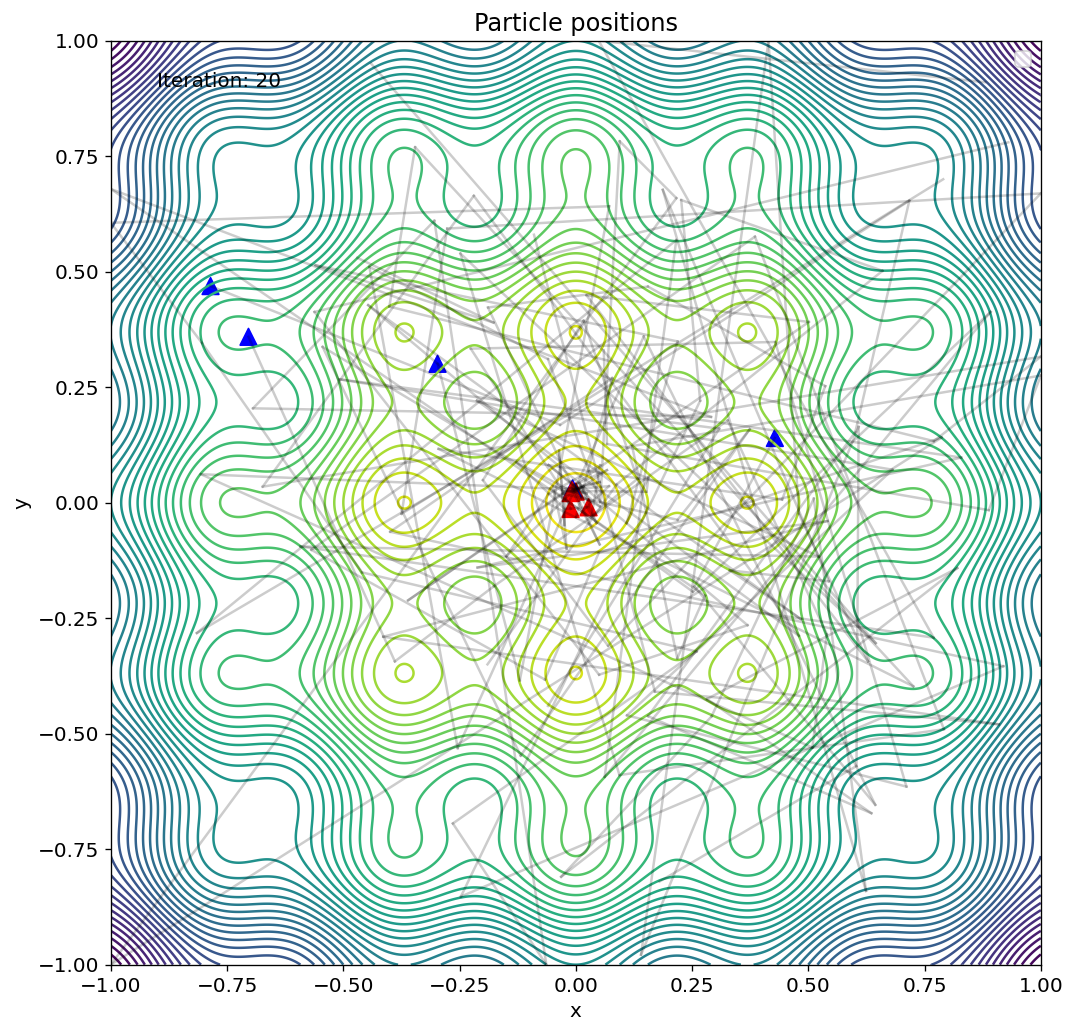

In [14]:
env.render(type="history", file_path="experiments/results/test_history2.gif")

In [51]:
exploiter_id = [0.]
exploiter_id

[0.0]